In [1]:
import os
import time as tm
import datetime as dt

# Data preparation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from collections import deque
import sqlalchemy as sa

# AI
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [ ]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

STOCK = 'AAPL'

# Current date
# date_now = tm.strftime('%Y-%m-%d')
date_now = dt.datetime(2025, 2, 1)
# date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')
date_3_years_back = (date_now - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [18]:
# LOAD DATA 
# data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip') 
DB_URI = f'postgresql://{os.environ["PG_USER"]}:{os.environ["PG_PASS"]}@{os.environ["PG_URL"]}/{os.environ["PG_DB"]}'
# QUERY = f"SELECT * FROM stocks_daily_price WHERE symbol in ('{'\', \''.join(STOCKS)}') AND date >= '{date_3_years_back}'"
QUERY = f"SELECT * FROM stocks_daily_price WHERE symbol = '{STOCK}' AND date >= '{date_3_years_back}'"

try:
    engine = sa.create_engine(DB_URI)
    with engine.connect() as connection:
        init_df = pd.read_sql_query(QUERY, index_col=['date'], parse_dates=['date'], con=connection)
        # data['date'] = pd.to_datetime(data['date'])
        print(init_df.shape)
        print(init_df.info())
        print(init_df.head())
except Exception as e:
    print(e)
finally:
    if 'engine' in locals():
        engine.dispose()

(749, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 749 entries, 2022-02-22 to 2025-02-14
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  749 non-null    object 
 1   volume  749 non-null    int64  
 2   close   749 non-null    float64
 3   open    749 non-null    float64
 4   high    749 non-null    float64
 5   low     749 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 41.0+ KB
None
           symbol     volume       close        open        high         low
date                                                                        
2022-02-22   AAPL   91162800  161.699890  162.349355  164.032095  159.564478
2022-02-23   AAPL   90009200  157.517685  162.900452  163.500726  157.202780
2022-02-24   AAPL  141147500  160.145111  150.147109  160.253358  149.576355
2022-02-25   AAPL   91974200  162.221481  161.227576  162.487165  158.304931
2022-02-28   AAPL   95056600  162.487122  

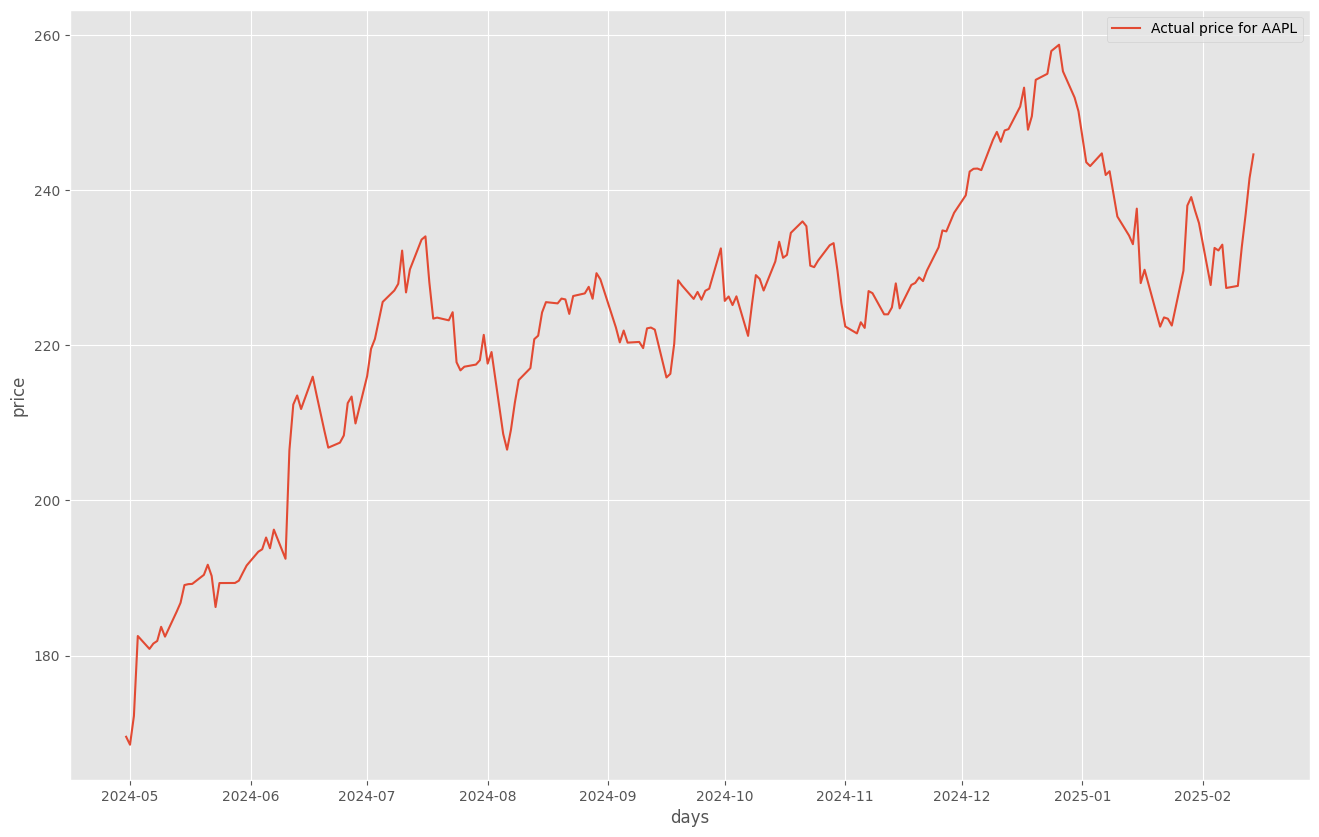

In [19]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [20]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'symbol', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [21]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [29]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [23]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  checkpoint_path = "../../models/F1.weights.h5"
  full_model_path = "../../models/F1.model.h5"
  cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[cp_callback],
            verbose=1)

  model.summary()
  model.save(full_model_path)

  return model

In [30]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80


/Users/jrizzo/Projects/ai/trading/pwbt/.devenv/state/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0401
Epoch 1: saving model to ../../models/F1.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0398
Epoch 2/80
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0036
Epoch 2: saving model to ../../models/F1.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0036
Epoch 3/80
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0045
Epoch 3: saving model to ../../models/F1.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0044
Epoch 4/80
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030
Epoch 4: saving model to ../../models/F1.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0030
Epoch 5/80
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027
Epoch 5: saving model to ../../models/F1.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0027
Epoch 6/80
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028
Epoch 6: saving model to ../../models/F1.weights.h5
93/93 ━━━━━━━━━━━━━━━━━━━━ 2

KeyboardInterrupt: 

In [25]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
  
  print(message)

AAPL prediction for upcoming 3 days (241.94$, 238.72$, 240.9$)


In [26]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [27]:
# Add predicted results to the table
date_now            = dt.date.today()
date_tomorrow       = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

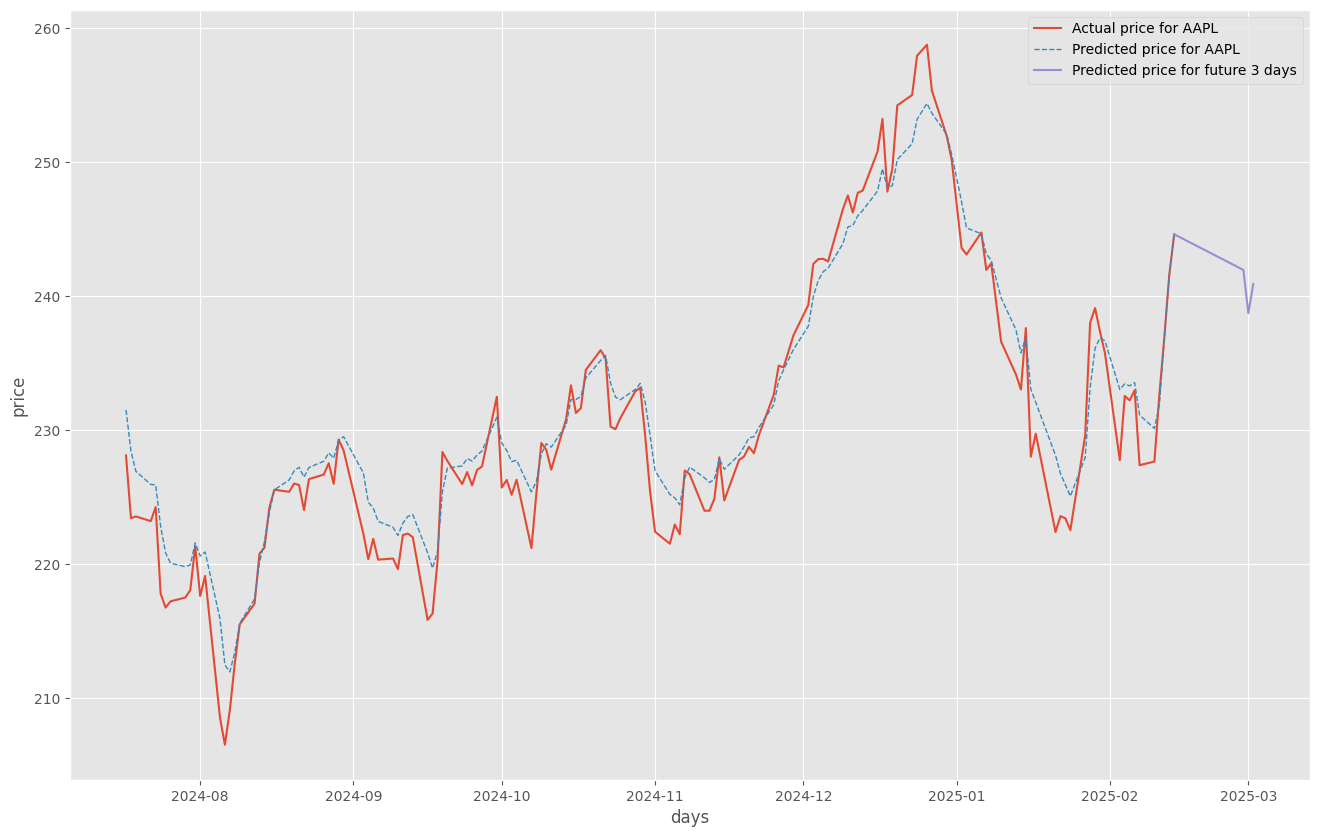

In [28]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()